In [1]:
##PROCEDURE:

# 1. set-up - import data and turn to greyscale
# 2. try to track where the movement is happening - frame (pixel) subtraction
# 3. PCA / SVD
# 4. SINDy

In [2]:
! pip install numpy
import numpy as np
import scipy.io
import matplotlib.pyplot as lib
from PIL import Image as im
import cv2 as cv

##EXTRACTING THE VIDEOS FROM THE .MAT FILES - FOR EACH CAMERA (THREE ANGLES): Merci pour ton aide, Nada ! 

cam1 = scipy.io.loadmat("cam1_1.mat")
datacam1 = cam1["vidFrames1_1"] 
#"vidFrames1_1" is the name of the element within the .mat file dictionary that is of interest
#extracting this for all three cameras

print("The dimensions of camera 1 are: ", datacam1.shape)
#print(cam1)
#print(datacam1)

cam2 = scipy.io.loadmat("cam2_1.mat")
datacam2 = cam2["vidFrames2_1"]

print("The dimensions of camera 2 are: ", datacam2.shape)
#print(cam2)
#print(datacam2)

cam3 = scipy.io.loadmat("cam3_1.mat")
datacam3 = cam3["vidFrames3_1"]

print("The dimensions of camera 3 are: ", datacam3.shape)
#print(cam3)
#print(datacam3)

#the dimensions are each printed as each camera shall have a different number of frames

The dimensions of camera 1 are:  (480, 640, 3, 226)
The dimensions of camera 2 are:  (480, 640, 3, 284)
The dimensions of camera 3 are:  (480, 640, 3, 232)


In [3]:
"""

##TURNING THE FRAMES INTO GREYSCALE: Merci pour ton aide, Nada ! 

def greyconversion(array):
    frames = []
    for i in range(array.shape[3]): #here every frame is defined, so that the greyscale reaches every frame
        image = im.fromarray(array[:,:,:,i])
        grey = np.mean(image,-1)
        frames.append(grey)
    gcam = np.stack(frames,axis=-1)
    return gcam

#running the defined function on each camera:

gcam1 = greyconversion(datacam1)
gcam2 = greyconversion(datacam2)
gcam3 = greyconversion(datacam3)

print("The new dimensions of camera 1 are: ", gcam1.shape)
print("The new dimensions of camera 2 are: ", gcam2.shape)
print("The new dimensions of camera 3 are: ", gcam3.shape)

#the frames have been kept as the third dimension in order to facilitate splitting space and time later

"""

'\n\n##TURNING THE FRAMES INTO GREYSCALE: Merci pour ton aide, Nada ! \n\ndef greyconversion(array):\n    frames = []\n    for i in range(array.shape[3]): #here every frame is defined, so that the greyscale reaches every frame\n        image = im.fromarray(array[:,:,:,i])\n        grey = np.mean(image,-1)\n        frames.append(grey)\n    gcam = np.stack(frames,axis=-1)\n    return gcam\n\n#running the defined function on each camera:\n\ngcam1 = greyconversion(datacam1)\ngcam2 = greyconversion(datacam2)\ngcam3 = greyconversion(datacam3)\n\nprint("The new dimensions of camera 1 are: ", gcam1.shape)\nprint("The new dimensions of camera 2 are: ", gcam2.shape)\nprint("The new dimensions of camera 3 are: ", gcam3.shape)\n\n#the frames have been kept as the third dimension in order to facilitate splitting space and time later\n\n'

In [4]:
"""

##DISPLAYING ALL OF THE GREYSCALE FRAMES: Merci pour ton aide, Nada ! 

def displaygrey(array):
    for i in range (array.shape[2]):
        lib.imshow(array[:,:,i],cmap = lib.cm.gray) #defining each frame as greyscale
        lib.show()

#gcam1_display = displaygrey(gcam1)
#gcam2_display = displaygrey(gcam2)
#gcam3_display = displaygrey(gcam3)

"""

'\n\n##DISPLAYING ALL OF THE GREYSCALE FRAMES: Merci pour ton aide, Nada ! \n\ndef displaygrey(array):\n    for i in range (array.shape[2]):\n        lib.imshow(array[:,:,i],cmap = lib.cm.gray) #defining each frame as greyscale\n        lib.show()\n\n#gcam1_display = displaygrey(gcam1)\n#gcam2_display = displaygrey(gcam2)\n#gcam3_display = displaygrey(gcam3)\n\n'

In [5]:
##CONVERTING THE DATA INTO VIDEOS:
#the data should not be made into greyscale

#camera 1:

frame_height, frame_width, RGB, frames = datacam1.shape
fourcc = cv.VideoWriter_fourcc(*"mp4v")
filename = "vidcam1.mp4"
output = cv.VideoWriter(filename, fourcc = fourcc, fps = 20, frameSize = (frame_width, frame_height)) 
#cv.VideoWriter orders width by height

for i in range(frames):
    output.write(datacam1[:,:,:,i])

In [7]:
#camera 2:

frame_height, frame_width, RGB, frames = datacam2.shape
fourcc = cv.VideoWriter_fourcc(*"mp4v")
filename = "vidcam2.mp4"
output = cv.VideoWriter(filename, fourcc = fourcc, fps = 20, frameSize = (frame_width, frame_height))

for i in range(frames):
    output.write(datacam2[:,:,:,i])

In [58]:
#camera 3:

frame_height, frame_width, RGB, frames = datacam3.shape
fourcc = cv.VideoWriter_fourcc(*"mp4v")
filename = "vidcam3.mp4"
output = cv.VideoWriter(filename, fourcc = fourcc, fps = 20, frameSize = (frame_width, frame_height))

for i in range(frames):
    output.write(datacam3[:,:,:,i])

In [10]:
##DECLARING THE TRACKERS:
#reference: https://broutonlab.com/blog/opencv-object-tracking

tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'MOSSE', 'CSRT']
tracker_type = tracker_types[1]

if tracker_type == 'BOOSTING':
    tracker = cv.legacy.TrackerBoosting_create()
if tracker_type == 'MIL':
    tracker = cv.TrackerMIL_create() 
if tracker_type == 'KCF':
    tracker = cv.TrackerKCF_create() 
if tracker_type == 'TLD':
    tracker = cv.legacy.TrackerTLD_create() 
if tracker_type == 'MEDIANFLOW':
    tracker = cv.legacy.TrackerMedianFlow_create() 
if tracker_type == 'MOSSE':
    tracker = cv.legacy.TrackerMOSSE_create()
if tracker_type == "CSRT":
    tracker = cv.TrackerCSRT_create()
#to make the motion tracking more generalized, MIL was selected, as it has a better resistance to noise

In [11]:
##SAVING THE XY-COORDINATES OF THE TRACKING RECTANGLE:
#creating a matrix of zeros to then enter the coordinates of the box

xymat1 = np.zeros((0,225)) #for the first camera with 226 frames - the camera shall only generate 225 data points
xymat2 = np.zeros((0,225)) #for the second camera - but we need to compensate for the number of frames in the first camera
xymat3 = np.zeros((0,225)) #for the third camera - but we need to compensate for the number of frames in the first camera

In [9]:
##OBJECT TRACKING WITH OPENCV: CAMERA 1
#this code allows us to select a box around the can of paint

#get the video file and read it
video1 = cv.VideoCapture('vidcam1.mp4')
ret, frame = video1.read()

#selecting the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [10]:
##STORING THE XY-COORDINATES: CAMERA 1

X1 = np.zeros((226,1))
Y1 = np.zeros((226,1))

i = 0

while True:
    ret,frame = video1.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) #image, start point, end point, colour (BGR), thickness
        XC1 = (x+w)/2
        YC1 = (y+h)/2
        print(XC1, YC1)
        X1[i] = XC1
        Y1[i] = YC1
    cv.imshow('Frame', frame) #need a positional argument, matrix form
    key = cv.waitKey(30)
    i += 1
    if key == ord('q'):
        break

video1.release()
cv.destroyAllWindows()

190.0 154.5
190.0 154.5
190.0 154.5
190.0 154.5
190.0 154.5
190.0 154.0
190.0 154.5
191.0 151.0
191.0 152.5
191.0 153.0
191.5 154.0
191.0 154.0
191.5 158.5
192.0 158.5
191.5 165.0
191.0 173.0
191.0 172.5
191.5 182.0
191.5 182.0
191.0 190.5
191.0 190.5
190.5 199.0
190.5 206.0
190.5 206.0
190.5 211.5
190.0 211.5
190.0 214.5
190.0 214.0
190.0 215.0
190.0 213.5
190.0 213.5
190.0 210.5
190.0 210.5
190.0 205.0
189.5 205.0
190.0 198.5
190.5 190.5
190.0 190.5
190.5 182.0
190.0 182.0
190.0 173.5
190.0 173.5
190.0 166.0
190.0 159.0
190.0 159.0
190.0 154.5
190.0 155.0
190.0 152.5
190.0 153.0
190.5 153.0
190.5 155.0
190.5 155.0
190.5 160.0
190.5 160.0
190.5 167.0
190.5 166.5
190.5 175.0
191.0 184.0
191.0 184.0
191.0 192.5
191.0 192.5
190.5 200.5
190.5 200.5
191.0 207.5
190.5 212.5
190.5 212.5
190.0 215.5
190.5 215.0
190.0 215.0
190.0 215.0
190.0 214.0
190.0 210.5
190.0 210.5
190.0 205.0
190.0 205.0
189.5 198.5
189.0 198.0
189.0 190.0
189.0 190.0
188.5 181.5
188.0 173.0
188.0 173.0
187.5 165.0
187.

In [16]:
##OBJECT TRACKING WITH OPENCV: CAMERA 2
#this code allows us to select a box around the can of paint

#get the video file and read it
video2 = cv.VideoCapture('vidcam2.mp4')
ret, frame = video2.read()

#selecting the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [ ]:
##STORING THE XY-COORDINATES: CAMERA 2
#as camera 1 has the fewest number of frames, we shall shape all 

X2 = np.zeros((284,1))
Y2 = np.zeros((284,1))

i = 0

while True:
    ret,frame = video2.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) #image, start point, end point, colour (BGR), thickness
        XC2 = (x+w)/2
        YC2 = (y+h)/2
        print(XC2, YC2)
        X2[i] = XC2
        Y2[i] = YC2
    cv.imshow('Frame', frame) #need a positional argument, matrix form
    key = cv.waitKey(30)
    i += 1
    if key == ord('q'):
        break

video2.release()
cv.destroyAllWindows()

166.0 181.0
166.0 177.0
166.0 172.5
166.0 167.0
165.5 159.5
166.0 160.0
166.5 152.0
165.5 143.0
165.5 135.5
166.5 128.5
166.5 128.5
167.0 121.0
167.5 114.5
167.0 109.5
166.5 105.5
167.0 105.5
167.0 102.5
166.5 101.5
167.0 102.0
166.5 103.0
166.5 103.0
165.5 105.5
165.5 110.5
165.0 117.0
164.5 124.5
164.5 124.5
164.0 133.0
163.5 141.5
163.5 149.5
163.0 157.5
163.0 158.0
163.0 165.0
163.5 172.0
163.5 178.0
163.0 183.0
163.0 183.0
163.5 185.5
163.5 186.0
163.5 185.0
165.0 183.0
165.0 183.0
165.5 179.0
166.0 174.5
167.0 169.0
167.0 162.0
167.0 162.0
168.0 155.0
169.0 146.5
169.5 138.5
169.5 131.0
169.5 131.0
170.0 123.5
170.5 117.0
170.5 111.0
170.5 111.0
171.0 106.5
172.0 103.5
171.5 101.5
171.5 102.0
171.5 102.0
171.5 103.0
172.0 106.0
172.0 110.0
172.0 115.5
172.0 115.5
171.0 122.5
170.5 130.5
170.5 138.5
170.0 147.0
169.5 147.0
169.5 155.5
169.0 164.0
168.5 172.0
168.5 178.0
169.0 178.0
169.0 182.0
168.5 185.0
167.5 186.0
167.5 185.5
167.5 185.5
167.5 184.0
168.0 180.0
168.5 175.0
170.

In [65]:
##OBJECT TRACKING WITH OPENCV: CAMERA 3
#this code allows us to select a box around the can of paint

#get the video file and read it
video3 = cv.VideoCapture('vidcam3.mp4')
ret, frame = video3.read()

#selecting the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [66]:
##STORING THE XY-COORDINATES: CAMERA 3
#as camera 1 has the fewest number of frames, we shall shape all 

X3 = np.zeros((232,1))
Y3 = np.zeros((232,1))

i = 0

while True:
    ret,frame = video3.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) #image, start point, end point, colour (BGR), thickness
        XC3 = (x+w)/2
        YC3 = (y+h)/2
        print(XC3, YC3)
        X3[i] = XC3
        Y3[i] = YC3
    cv.imshow('Frame', frame) #need a positional argument, matrix form
    key = cv.waitKey(30)
    i += 1
    if key == ord('q'):
        break

video3.release()
cv.destroyAllWindows()

196.5 159.0
189.5 157.5
189.5 157.5
183.5 156.0
183.5 156.0
179.5 155.0
178.0 155.0
177.5 155.0
178.5 155.0
178.0 155.5
180.5 155.5
180.5 155.5
185.0 156.0
191.5 156.5
191.5 157.0
199.5 157.5
199.5 157.5
208.0 158.5
207.5 158.5
217.0 159.5
224.5 160.5
225.0 160.5
231.5 161.5
232.0 161.5
237.5 162.0
238.0 162.5
241.0 163.0
242.0 164.0
242.0 164.0
240.5 163.5
240.5 163.5
237.5 163.0
237.5 163.0
232.0 162.0
225.0 161.5
225.0 161.5
217.0 159.5
217.0 159.5
209.5 159.0
209.5 159.0
201.5 157.5
194.5 156.5
195.0 156.5
189.5 155.5
189.5 155.5
185.0 154.0
185.0 154.0
183.0 154.0
183.5 154.0
183.5 154.0
186.5 155.0
186.5 155.0
190.5 155.5
190.5 155.5
197.0 157.0
204.5 157.5
204.0 157.5
211.5 158.5
211.5 158.5
219.5 159.5
219.5 159.5
227.0 160.5
233.5 162.0
233.5 162.0
238.0 163.0
238.0 163.0
240.0 163.0
240.0 163.0
240.0 163.0
238.0 162.0
238.0 162.0
234.0 161.5
234.5 161.5
228.5 159.5
228.5 159.5
222.5 159.0
214.0 157.5
214.0 157.5
206.0 156.0
206.0 156.0
198.5 155.0
198.5 155.0
191.5 154.5
186.

In [67]:
print(xymat1.shape)
print(xymat2.shape)
print(xymat3.shape)

(0, 225)
(0, 225)
(0, 225)


In [68]:
X1 = np.resize(X1, (225,1)) #due to the size of the xy-matrix
Y1 = np.resize(Y1, (225,1)) #due to the size of the xy-matrix

X2 = np.resize(X2, (225,1)) #due to the size of the xy-matrix
Y2 = np.resize(Y2, (225,1)) #due to the size of the xy-matrix

X3 = np.resize(X3, (225,1)) #due to the size of the xy-matrix
Y3 = np.resize(Y3, (225,1)) #due to the size of the xy-matrix

In [69]:
X1 = np.reshape(X1, (1,225)) #to match the matrix format
Y1 = np.reshape(Y1, (1,225)) #to match the matrix format

X2 = np.reshape(X2, (1,225)) #to match the matrix format
Y2 = np.reshape(Y2, (1,225)) #to match the matrix format

X3 = np.reshape(X3, (1,225)) #to match the matrix format
Y3 = np.reshape(Y3, (1,225)) #to match the matrix format

In [70]:
xymat1 = np.append(xymat1, X1, axis = 0)
xymat2 = np.append(xymat2, X2, axis = 0)
xymat3 = np.append(xymat3, X3, axis = 0)

In [71]:
xymat1 = np.append(xymat1, Y1, axis = 0)
xymat2 = np.append(xymat2, Y2, axis = 0)
xymat3 = np.append(xymat3, Y3, axis = 0)

In [72]:
print(xymat1.shape)
print(xymat1)

print(xymat2.shape)
print(xymat2)

print(xymat3.shape)
print(xymat3)

(2, 225)
[[192.  192.  192.  192.  192.  192.  192.  192.5 194.  193.5 194.  194.
  194.  194.  194.  193.5 193.5 193.5 193.5 193.  193.  192.5 192.5 192.5
  192.5 192.5 192.5 192.5 192.5 193.  192.5 192.5 192.5 192.5 192.5 193.
  193.  193.5 193.5 193.5 194.  194.  194.  194.5 194.5 194.5 194.5 195.
  195.  195.  195.  195.  195.  195.  195.  195.  195.  195.  195.  195.
  195.  195.  195.  195.  195.  195.  194.5 194.5 194.  194.  194.  194.
  194.  194.  194.  194.  194.  193.5 193.5 193.5 193.  193.  193.  193.
  193.  193.  193.  193.  193.  193.  193.  193.  192.5 192.5 192.  192.
  192.  192.  192.  192.  192.  192.  192.  192.  192.  192.  192.5 192.5
  193.5 193.5 193.5 193.5 194.  194.5 195.  195.  195.5 195.5 195.5 196.5
  196.  196.5 197.  197.  197.  197.5 197.5 197.  197.  197.  197.  197.5
  197.5 197.5 197.5 198.  198.  198.  198.  198.  197.  197.  197.  197.
  197.  196.5 196.5 196.  195.5 195.5 195.  195.  194.5 194.5 194.  194.
  194.  194.  194.  194.  194.  194.5 

In [73]:
xymat = np.zeros((0,225))

xymat = np.append(xymat, xymat1, axis = 0)

In [74]:
xymat = np.append(xymat, xymat2, axis = 0)

In [75]:
xymat = np.append(xymat, xymat3, axis = 0)

In [76]:
print(xymat.shape)
print(xymat)

(6, 225)
[[192.  192.  192.  ... 198.5 198.5 198. ]
 [154.5 154.5 154.5 ... 207.  207.5 213. ]
 [166.  166.  166.  ... 176.  175.  175. ]
 [183.  178.5 174.  ... 115.  119.5 119.5]
 [196.5 189.5 189.5 ... 224.5 229.5 229.5]
 [159.  157.5 157.5 ... 152.5 152.5 152.5]]


In [77]:
##COMPUTING THE MEAN MATRIX:
#this shall allow to plot the X and Y values along the origin

#identifying the separate rows of the xy-matrix:

row1X = xymat[0,:]
row1Y = xymat[1,:]
row2X = xymat[2,:]
row2Y = xymat[3,:]
row3X = xymat[4,:]
row3Y = xymat[5,:]

#computing the mean of every row separately:

meanX1 = np.mean(row1X)
meanY1 = np.mean(row1Y)
meanX2 = np.mean(row2X)
meanY2 = np.mean(row2Y)
meanX3 = np.mean(row3X)
meanY3 = np.mean(row3Y)

#computing the rows without their mean:

xymat[0,:] = xymat[0,:] - meanX1
xymat[1,:] = xymat[1,:] - meanY1
xymat[2,:] = xymat[2,:] - meanX2
xymat[3,:] = xymat[3,:] - meanY2
xymat[4,:] = xymat[4,:] - meanX3
xymat[5,:] = xymat[5,:] - meanY3

print(xymat)
#the mean should be removed to run PCA as the results will look awful otherwise

[[ -2.82444444  -2.82444444  -2.82444444 ...   3.67555556   3.67555556
    3.17555556]
 [-30.59111111 -30.59111111 -30.59111111 ...  21.90888889  22.40888889
   27.90888889]
 [ -6.11333333  -6.11333333  -6.11333333 ...   3.88666667   2.88666667
    2.88666667]
 [ 41.23777778  36.73777778  32.23777778 ... -26.76222222 -22.26222222
  -22.26222222]
 [-12.89333333 -19.89333333 -19.89333333 ...  15.10666667  20.10666667
   20.10666667]
 [  3.82         2.32         2.32       ...  -2.68        -2.68
   -2.68      ]]


In [206]:
np.save('xymat', xymat)

In [6]:
xymat = np.load('xymat.npy')

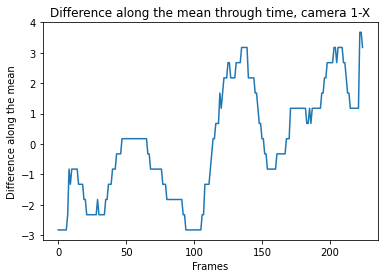

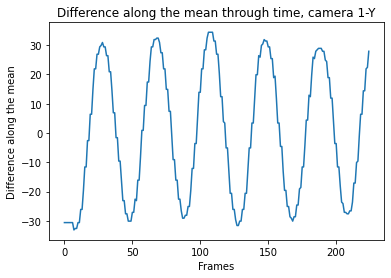

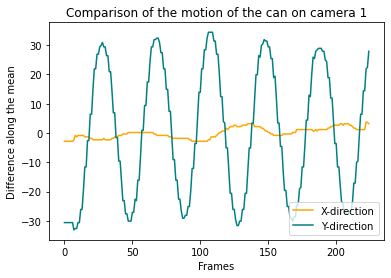

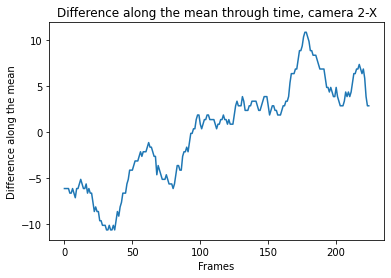

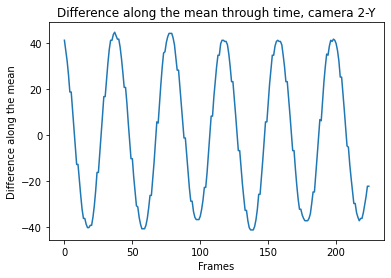

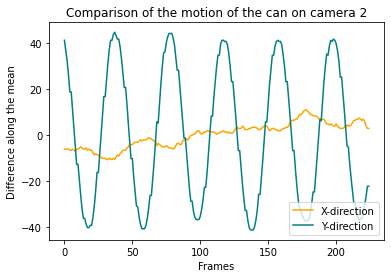

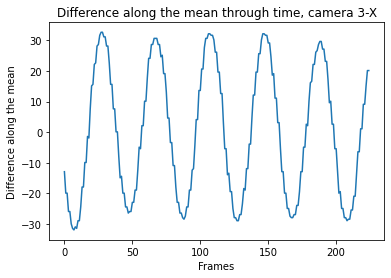

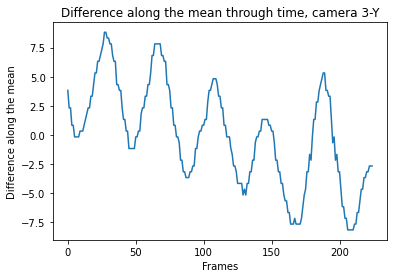

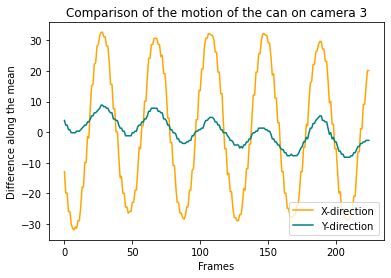

In [7]:
lib.plot(xymat[0,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 1-X')
lib.savefig("1-X.png")
lib.show()

lib.plot(xymat[1,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 1-Y')
lib.savefig("1-Y.png")
lib.show()

lib.plot(xymat[0,:], c = 'orange', label = 'X-direction')
lib.plot(xymat[1,:], c = 'teal', label = 'Y-direction')
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Comparison of the motion of the can on camera 1')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("1.png")
lib.show()

lib.plot(xymat[2,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 2-X')
lib.savefig("2-X.png")
lib.show()

lib.plot(xymat[3,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 2-Y')
lib.savefig("2-Y.png")
lib.show()

lib.plot(xymat[2,:], c = 'orange', label = 'X-direction')
lib.plot(xymat[3,:], c = 'teal', label = 'Y-direction')
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Comparison of the motion of the can on camera 2')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("2.png")
lib.show()

lib.plot(xymat[4,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 3-X')
lib.savefig("3-X.png")
lib.show()

lib.plot(xymat[5,:])
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Difference along the mean through time, camera 3-Y')
lib.savefig("3-Y.png")
lib.show()

lib.plot(xymat[4,:], c = 'orange', label = 'X-direction')
lib.plot(xymat[5,:], c = 'teal', label = 'Y-direction')
lib.xlabel('Frames')
lib.ylabel('Difference along the mean')
lib.title('Comparison of the motion of the can on camera 3')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("3.png")
lib.show()

#it makes sense that the major difference would appear in the y-values of cameras 1 and 2 and the x-values of camera 3
#it further makes sense that the difference appears periodic
#this means that the approximation of the motion using SINDy will require trigonometric functions 
#(or linear pendulum equation / polynomial functions that approximate the differentials of the positional information, which are velocity and acceleration)
#PCA shall keep two degrees of information, as according to Newton's second law, velocity and acceleration are required

In [8]:
##RUNNING PCA: STEP 1 - COVARIANCE MATRIX
#this allows to determine the dominant spatial directions of motion (how one moves around in the projected plane)

covmat = np.cov(xymat)

In [9]:
##DIAGONALIZING THROUGH SVD: REMOVING REDUNDANCIES

U, S, VT = np.linalg.svd(xymat)
UT = np.transpose(U) 

In [10]:
##RUNNING PCA: STEP 2 - COVARIANCE MATRIX WITHOUT TIME

Y = np.matmul(UT, xymat) #these allow for a change in basis, effectively removing time
covmatY = np.cov(Y) #determining the dominant spatial directions of motion without time

print(covmatY.shape)
print(covmatY) #it is a diagonal matrix

(6, 6)
[[ 9.63703175e+02  3.32940025e-13 -7.61295788e-14 -2.31433920e-13
  -1.82710989e-14  5.32907052e-15]
 [ 3.32940025e-13  8.57154449e+02 -1.90831478e-13 -1.24662185e-14
  -3.34970147e-14 -2.17984361e-13]
 [-7.61295788e-14 -1.90831478e-13  3.67163815e+01 -1.15621798e-14
  -5.86039154e-15 -1.67485073e-14]
 [-2.31433920e-13 -1.24662185e-14 -1.15621798e-14  5.41831366e+00
   5.07530526e-16  1.13401352e-15]
 [-1.82710989e-14 -3.34970147e-14 -5.86039154e-15  5.07530526e-16
   1.99934154e+00  2.22044605e-16]
 [ 5.32907052e-15 -2.17984361e-13 -1.67485073e-14  1.13401352e-15
   2.22044605e-16  1.78283313e+00]]


(6,)
[464.61759674 438.18100898  90.68886068  34.83822985  21.16252594
  19.98385903]


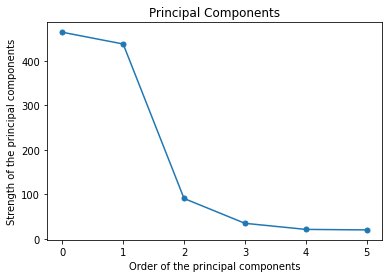

In [11]:
print(S.shape)
print(S)
#the first two principal components maintain the majority of the information

lib.plot(S, marker = 'o', markersize = 5)
lib.xlabel('Order of the principal components')
lib.ylabel('Strength of the principal components')
lib.title('Principal Components')
lib.savefig("Principal_Components.png")
lib.show()

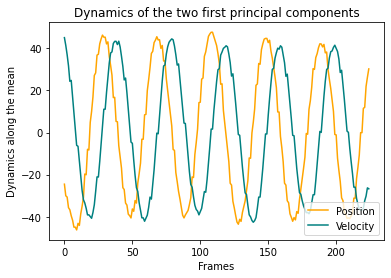

In [12]:
lib.plot(S[0]*VT[0,:], c = 'orange', label = 'Position') #this is velocity (we need the time component here)
lib.plot(S[1]*VT[1,:], c = 'teal', label = 'Velocity') #this is acceleration (we need the time component here)
lib.xlabel('Frames')
lib.ylabel('Dynamics along the mean')
lib.title('Dynamics of the two first principal components')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("PCA.png")
lib.show()
#as velocity is the derivative of position, the first component shall represent position, and the second, velocity

In [13]:
! pip install pysindy
import pysindy as py

In [14]:
model = py.SINDy()
print(model)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(), optimizer=STLSQ())


In [15]:
xymat_reduced = np.transpose(U[:,0:2])@xymat

print(xymat_reduced.shape)
print(xymat_reduced)

xymat_reducedT = np.transpose(xymat_reduced)
print(xymat_reducedT.shape)
print(xymat_reducedT)

(2, 225)
[[-2.45424156e+01 -3.00438412e+01 -3.06622864e+01 -3.56937131e+01
  -3.67220507e+01 -3.95266061e+01 -4.16426896e+01 -4.49430687e+01
  -4.49502496e+01 -4.62694229e+01 -4.31498688e+01 -4.41142991e+01
  -3.86916459e+01 -3.50688949e+01 -3.09068604e+01 -1.97086149e+01
  -2.00546001e+01 -7.95727817e+00 -8.29775625e+00  4.82135710e+00
   9.99242775e+00  1.69138213e+01  2.71185044e+01  2.83474833e+01
   3.68022741e+01  3.71903310e+01  4.21650907e+01  4.44677923e+01
   4.62864820e+01  4.53107436e+01  4.53152116e+01  4.21194520e+01
   4.30814779e+01  3.61423421e+01  3.19114619e+01  2.72476180e+01
   1.66034804e+01  1.67388492e+01  5.31377446e+00  5.10281711e+00
  -6.19299043e+00 -1.15118094e+01 -1.68810910e+01 -2.61931137e+01
  -2.70864234e+01 -3.35047575e+01 -3.44715923e+01 -3.87910012e+01
  -3.94884786e+01 -4.05879367e+01 -3.63090474e+01 -3.74109100e+01
  -3.23263304e+01 -3.35093375e+01 -2.40153576e+01 -1.95151199e+01
  -1.45332783e+01 -3.18322427e+00 -3.18562874e+00  8.41654548e+00
 

In [18]:
X1 = xymat_reducedT[:,0]
Y1 = xymat_reducedT[:,1]

print(X1.shape)

(225,)


In [31]:
featurenames = ['X1', 'Y1']
optim = py.STLSQ(threshold = 0.1)
t = np.arange(0,11,11/225)

In [32]:
model = py.SINDy(feature_names = featurenames, optimizer = optim)

In [33]:
model.fit(xymat_reducedT, t) #frames by the duration of the video

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['X1', 'Y1'],
      optimizer=STLSQ())

In [34]:
print(model)
model.print()

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['X1', 'Y1'],
      optimizer=STLSQ())
(X1)' = 4.668 1 + -3.317 Y1
(Y1)' = -6.882 1 + 2.949 X1


In [23]:
from scipy.integrate import odeint

def function(z,t):
    a=-2.454
    b=-3.004
    c=4.509
    d=4.143

    dxdt = a + b*z[1]
    dydt = c + d*z[0]
    dzdt = [dxdt,dydt]

    return dzdt

NameError: name 'z' is not defined

(226, 2)


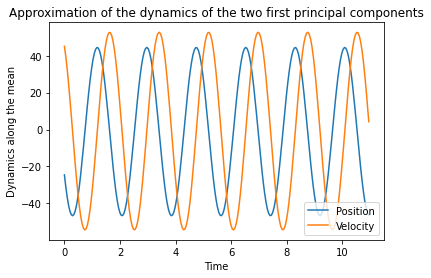

In [27]:
##INITIAL CONDITION:

z0 = [xymat_reducedT[0,0], xymat_reducedT[0,1]]

#solving the ODE:
z = odeint(function, z0, t)

print(z.shape)

lib.plot(t,z[:,0], label = 'Position') #x(t) = position
lib.plot(t,z[:,1], label = 'Velocity') #y(t) = velocity
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the two first principal components')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy.png")
lib.show()

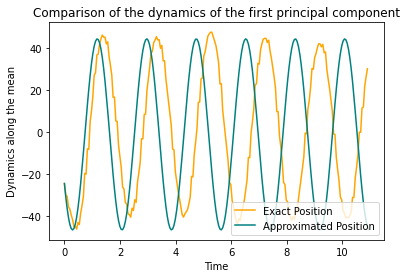

In [231]:
lib.plot(t[0:225], S[0]*VT[0,:], c = 'orange', label = 'Exact Position') #exact
lib.plot(t, z[:,0], c = 'teal', label = 'Approximated Position') #approximation
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the first principal component')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare1.png")
lib.show()

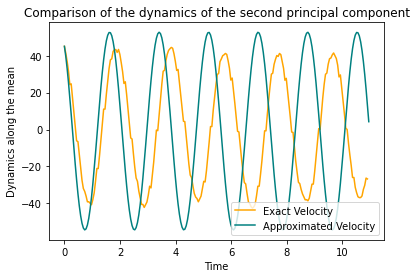

In [232]:
lib.plot(t[0:225], S[1]*VT[1,:], c = 'orange', label = 'Exact Velocity') #exact
lib.plot(t, z[:,1], c = 'teal', label = 'Approximated Velocity') #approximation
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the second principal component')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare2.png")
lib.show() 